In [2]:
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
from os.path import join
import os
import html5lib
import lxml
import re
from time import sleep
from IPython.display import clear_output
from selenium.webdriver.support.ui import Select
import matplotlib.pyplot as plt
import random
import time
import requests
import pickle
import urllib.parse
import shutil  

In [3]:
root_folder = '/home/sandeep/Desktop/Projects/Python/Patna/'

## Issues

1. Some case types do not appear in the dropdown list in case search on the HC website
2. Thos not appearing are approx 25% of the cases

### Get Case Type codes

In [3]:
#browser = webdriver.Chrome('/home/sandeep/Desktop/Projects/Python/Patna/chromedriver')
#url = 'http://patnahighcourt.gov.in/'
#browser.get(url)

In [258]:
# Click on the CASE STATE tab to load the dropdown lists

In [38]:
# get visible text and values from the dropdown list in case status search
#select_civ = Select(browser.find_element_by_name("ctl00$MainContent$ddlCTypeCivil"))
#select_cri = Select(browser.find_element_by_name("ctl00$MainContent$ddlCTypeCri"))

In [56]:
# dict to convert the dropdown list visible text in to a parameter in the POST call
#case_type_dict = {**{re.search(r'\[.*?\]', x.text)[0][1:-1]: (True, x.get_attribute('value')) for x in select_civ.options}, 
#                  **{re.search(r'\[.*?\]', x.text)[0][1:-1]: (False, x.get_attribute('value')) for x in select_cri.options}}
 

In [25]:
case_type_dict = {'ADM. SUIT': (True, '42'), 'CRT. APPEAL': (True, '39'), 'C.Misc.': (True, '44'),
                  'C.REF.': (True, '12'), 'C. REV.': (True, '11'), 'C.R.': (True, '8'),
                  'CWJC': (True, '15'), 'COM. APP': (True, '50'), 'COMP. APP.': (True, '37'),
                  'COMP. APP.(DB)': (True, '38'), 'COM. APPLIC': (True, '20'), 'COM PET': (True, '21'),
                  'COMPAN. APL': (True, '34'), 'E.P.': (True, '14'), 'FA': (True, '1'),
                  'L.P.A': (True, '3'), 'MAT. REF.': (True, '19'), 'MAT. SUIT': (True, '33'),
                  'MA': (True, '2'), 'MJC': (True, '10'), 'MONEY SUIT': (True, '41'),
                  'PATENT CASE': (True, '30'), 'REQ. CASE': (True, '36'), 'SCA': (True, '40'),
                  'SA': (True, '9'), 'SLP': (True, '51'), 'TAX': (True, '4'), 'TEST CASE': (True, '17'),
                  'TEST SUIT': (True, '18'), 'T.S.': (True, '22'), 'CR. APP(341': (False, '35'),
                  'CR. APP (DB)': (False, '5'), 'CR. APP (SJ)': (False, '24'),
                  'CR.APP(U/S)': (False, '27'), 'CR. MISC.': (False, '6'), 'CR. REF.': (False, '29'),
                  'CR. REV.': (False, '7'), 'CR. WJC': (False, '16'), 'D. REF.': (False, '28'),
                  'G. APP. (DB)': (False, '25'), 'G.APP.(SJ)': (False, '31'), 
                  'OR. CR. MISC': (False, '23'), 'OCR.MISC(DB)': (False, '32'), 'SLA': (False, '26')}

### 1. Convert case number into form data for the request

In [11]:
def convert_case_no_to_params(case_no):
    # output tuple of (is_civil, civ_case_type, civ_case_no, civ_year, cri_case_type, cri_case_no, cri_year)
    
    params = re.split(r'(-|/)',case_no)[::2]

    
    # check if the case type is in an option in the dropdown list in the HC site
    _ = case_type_dict.get(params[0], '0')

    if _=='0':
        to_scrape = False
        is_civil, civ_case_type, civ_case_no, civ_year = '', '', '', ''
        cri_case_type, cri_case_no, cri_year = '', '', ''
        
        return to_scrape, is_civil, civ_case_type, civ_case_no, civ_year, cri_case_type, cri_case_no, cri_year
    else:
        to_scrape = True
        is_civil = _[0]
        
    if is_civil:
        civ_case_type, civ_case_no, civ_year = _[1], params[1], params[2]
        cri_case_type, cri_case_no, cri_year = '5', '', ''
    else:
        civ_case_type, civ_case_no, civ_year = '42', '', ''
        cri_case_type, cri_case_no, cri_year = _[1], params[1], params[2]
    
    return to_scrape, is_civil, civ_case_type, civ_case_no, civ_year, cri_case_type, cri_case_no, cri_year
        
        
    
    

### 2. Function to make the appropriate request

1. First make a request to get sessionID cookie, VIEWSTATE, EVENTVALIDATION etc
2. Make a post request with the cookies and form data from the above function for a case to get the static url associated to the case_no. Note that this is the redirect url.
3. scrape the content from the static url

In [12]:
def get_case_details(to_scrape, is_civil, civ_case_type, civ_case_no, civ_year, cri_case_type, cri_case_no, cri_year):
    
    if not to_scrape:
        return False, '', ''
    
    if is_civil:
        fname = '_'.join([str(int(is_civil)), civ_case_type, civ_case_no, civ_year])
    else:
        fname = '_'.join([str(int(is_civil)), cri_case_type, cri_case_no, cri_year])
        
    # page containing the case wise search
    url = 'http://patnahighcourt.gov.in/'  
    
    # Get cookies
    s = requests.Session()
    response = s.get(url)
    cookies = s.cookies.get_dict()
    headers = {
        'Connection': 'keep-alive',
        'Cache-Control': 'max-age=0',
        'Origin': 'http://patnahighcourt.gov.in',
        'Upgrade-Insecure-Requests': '1',
        'Content-Type': 'application/x-www-form-urlencoded',
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.87 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'Referer': 'http://patnahighcourt.gov.in/',
        'Accept-Language': 'en-US,en;q=0.9,bn;q=0.8',
    }
    data_session = {x['name']:x['value'] for x in BeautifulSoup(response.text).find_all('input', attrs = {'type': "hidden"})}
    
    # Input form data parsed from the case number
    data_params = {
        '__EVENTTARGET': '',
        '__EVENTARGUMENT': '',
        '__SCROLLPOSITIONX': '0',
        '__SCROLLPOSITIONY': '107',
        'ctl00$txtSearch': '',
        'ctl00$MainContent$ddlCTypeCivil': civ_case_type,
        'ctl00$MainContent$txtCaseNoCivil': civ_case_no,
        'ctl00$MainContent$txtCaseYear': civ_year,
        'ctl00$MainContent$ddlCTypeCri': cri_case_type,
        'ctl00$MainContent$txtCaseNoCri': cri_case_no,
        'ctl00$MainContent$txtCaseYearCri': cri_year
        }

    
    if is_civil:
        data_search_type = {'ctl00$MainContent$btnSearchCivil': 'Search'}
    else:
        data_search_type = {'ctl00$MainContent$btnSearchCri': 'Search'}
    
    
    # Make a post request
    response = requests.post('http://patnahighcourt.gov.in/', headers=headers,
                             cookies=cookies,
                             data={**data_session, **data_params, **data_search_type}, verify=False)
    
    # Get static url fragment for case details
    static_url_fragment = BeautifulSoup(response.text).find('form')['action']
    
      
    
    # get the case_details page
    r = requests.get(url+static_url_fragment)
    BeautifulSoup(r.text).find('div', attrs={'class': 'pageBody'})
    body = BeautifulSoup(r.text).find('div', attrs={'class':'pageBody'})

    print('Status Code: %d' %r.status_code)

    return to_scrape, fname+'_'+static_url_fragment.split('.aspx?CNO=')[-1], body

### Save html page

In [13]:
def save_page(success_status, fname, content):
    if success_status:
        with open(join(root_folder, 'data','select_cases_elec/', fname+'.html'), 'w') as f:
            f.write(str(content))

### Loop over case numbers from saved judges cases csv file

In [14]:
case_nos = list(pd.read_csv(os.path.join(root_folder, 'data/cases_by_judge_patna.csv'))['Case Number'])

In [15]:
times, rate = [], []

In [16]:
t=0
r=0

In [100]:
s=0
num = 0
t_start = time.time()

start,end = 30851, 50000
for i, case_no in enumerate(case_nos[start: end]):
    try:
        t1 = time.time()
        sleep(s)
        clear_output()
        print('working on %d out of %d' %((start+i+1), end))
        print('Number of cases scraped %d out of %d' %(len(
            os.listdir(os.path.join(root_folder, 'data/cases_from_HC'))), end))
        print('response time: %.2f' %t)
        print('rate: %.2f' %r)
        params = convert_case_no_to_params(case_no)    
        save_page(*get_case_details(*params))
        t2 = time.time()
        t = t2-t1
        times.append(t)
        num+=1
        r=(60*num)/(t2-t_start)
        rate.append((r, time.time()))
                    
        s = 0 if random.uniform(0,1)<0.05 else s

    except TimeoutError:
        s+=1
        sleep(10)
    except KeyboardInterrupt:
        break
    except:
        pass




working on 30852 out of 50000
Number of cases scraped 23277 out of 50000
response time: 0.00
rate: 0.00


### To-Do

1. Scrape all the cases
2. Find a way of getting case details for the case types which are not in the dropdown list
3. parse the html page to extract a csv file with case info
4. Merge case info with the judge info
5. Make lawyer judge network

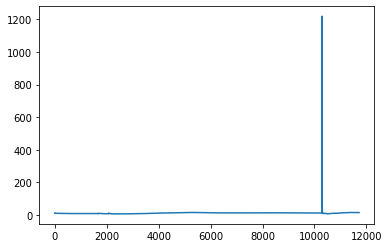

In [42]:
plt.plot([x[0] for x in rate]);

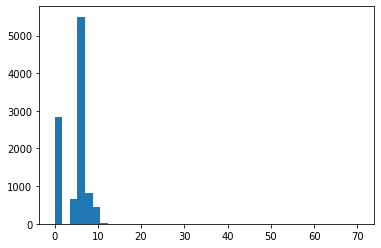

In [36]:
plt.hist(times, bins=40);

### Scrape select cases from around the elections

In [17]:
with open('select_cases_elec.pkl', 'rb') as f:
    case_nos = pickle.load(f)

In [27]:
case_nos = list(case_nos)

In [28]:
errors = []

In [29]:
times, rate = [], []

In [30]:
t=0
r=0

In [48]:
s=0
num = 0
t_start = time.time()

start,end = 44_324, 60_000
for i, case_no in enumerate(case_nos[start: end]):
    try:
        t1 = time.time()
        sleep(s)
        clear_output()
        print('working on %d out of %d' %((start+i+1), end))
        print('Number of cases scraped %d out of %d' %(len(
            os.listdir(os.path.join(root_folder, 'data/select_cases_elec'))), end))
        print('Number of errors: %d' %len(errors))
        print('response time: %.2f' %t)
        print('rate: %.2f' %r)
        params = convert_case_no_to_params(case_no)    
        save_page(*get_case_details(*params))
        t2 = time.time()
        t = t2-t1
        times.append(t)
        num+=1
        r=(60*num)/(t2-t_start)
        rate.append((r, time.time()))
                    
        s = 0 if random.uniform(0,1)<0.05 else s

    except TimeoutError:
        s+=1
        sleep(10)
    except KeyboardInterrupt:
        break
    except:
        errors.append(case_no)




working on 44520 out of 60000
Number of cases scraped 47035 out of 60000
Number of errors: 67
response time: 23.89
rate: 3.06


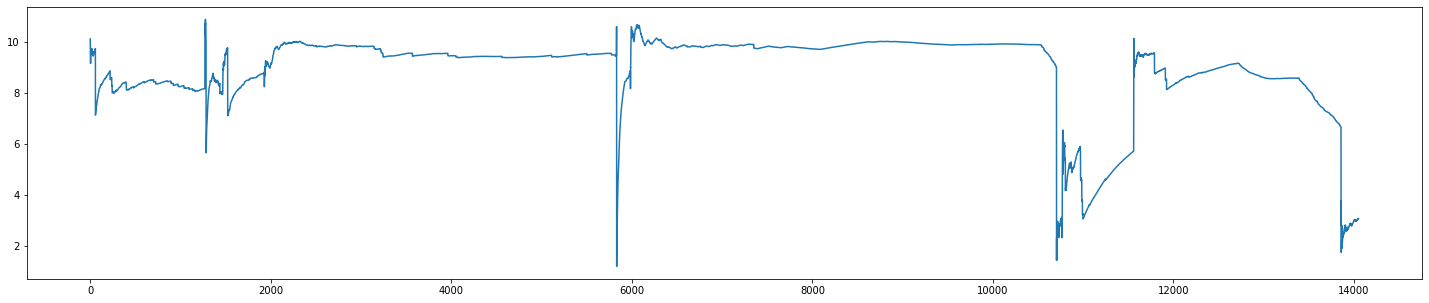

In [49]:
plt.figure(figsize=(25, 5))
plt.plot([x[0] for x in rate]);

In [233]:
def get_all_docs(data_folder, fname):
    
    if '.html' not in fname:
        return
    
    new_folder_name = fname.replace('.html', '')
    url_frag = fname.split('_')[-1].split('.html')[0]
    CNO = urllib.parse.unquote(url_frag)

    
    if not os.path.exists(os.path.join(data_folder, new_folder_name)):
        os.mkdir(os.path.join(data_folder, new_folder_name))
        
    # move file to the new folder 
    source = os.path.join(data_folder, fname)
    destination = os.path.join(data_folder, new_folder_name, fname)
    
    shutil.move(source, destination)    
    
  
    
    with open(destination, 'r') as f:
        d = BeautifulSoup(f.read())
    
    link_options = ['ctl00$'+x['href'].split('ctl00$')[-1].split('$LinkButton1')[0]+'$LinkButton1' 
     for x in d.find_all('a') if x.get_attribute_list('href')[0]]
    
    for option in link_options:
        
        cookies = {
            'ASP.NET_SessionId': '2hjg4h3a4ilkwbtau32vx0kl',
            'CaptchaImageText': '729',
        }

        headers = {
            'Connection': 'keep-alive',
            'Cache-Control': 'max-age=0',
            'Upgrade-Insecure-Requests': '1',
            'Origin': 'http://patnahighcourt.gov.in',
            'Content-Type': 'application/x-www-form-urlencoded',
            'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.92 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
            'Referer': 'http://patnahighcourt.gov.in/CaseStatus.aspx?CNO=QlJIQzAxMDM2MzgwMjAwOA%3d%3d-fRjT2YXKA4I%3d',
            'Accept-Language': 'en-US,en;q=0.9,bn;q=0.8',
        }

        params = (
            ('CNO', CNO),
        )

        data = {
          '__EVENTTARGET':option,
          '__EVENTARGUMENT': '',
          '__VIEWSTATE': 'bPbbAfU0x2ZCt0fBy8vya+7mmU/W/FNinmRh/Br/4DvBHUlegNhkaLXJn3X6522DTPxBS14bZVRvKguNa7EXxOkAdEK3biVx+Ds0B3GyeRdDdCPVjeFdypwlCha+JADSW8rniR6Sz+h4P7DZGDf9FwGQrVSoQ73gb37QUOiQwW+QM99A1FSK0DHuLfd9hWuiMMktraHHudWI2px0YvjkPM95hX1DqmBw53TeXSnw/HvYxgc1hBSOP5mbMiOF1oHZgz44PFPZ34ofxoyKzEUO8vFfN6i5eXL+1qJpf8FDqa5UWbSKzHQp9J+FrHI1cGdLPmbjXmHS0YxkyNUSyxn9hLc6NpokXD30CodMxyYfEB8K3/wVdYAzgXV+j7+uP4PxEwmG24xdIAhzDkBwPBSH2goh3281X6Q04iG4Kq4fNG0dWA9BnoQs8ofqIqdmf4BGCc4Hr9yBaW/OWM2MQ0JGONAfq+Y4g37MzGEEWeB4x0zX/FGYvObF8qi0DS1crDk0wGJ/h3IFX5hE5o6SfEytpxRy+4t7WM9tzuxRuzxk5A3nksUBzEsgbDmo9/gRS9+vlgxftbGOb7qDCyfdYkeeSeqg0NQjcOhiu49/GneCpcG9gmGQFiup/r/RMxj/J/SG/36FwFCxQqQZwxqNO+AwvHIz82pgX4KjtLBZR5ILPxCz31jju1RVyjhS/o7+59MkkstSsBgLewfSKUyWOuUBFTICxThnGuNMEMbIXqsMKJAWeWFtJmxdKNn0Hko0xJPypqkKo+H8awGRCOstK2cCihs8UrfL6TyYNQj2wdkDZ73lCxXJxaUE0okfrmUFBM4wfMncne3mv0K9CgYRUl3Ub/+cn2nX8Haaq2aUlDTeoSkpHWGwSTSzt1MOyuHTCBEsEkwnt8rWOdn2rUec4122BuMmCahNAZd9lGFner3Wc2yjxODdRvWZ+gLx7NkJMoJrPKeR2Ydo7hoAnquRzMA3pbrXbmnTi2+yG4R+4XfXVOPbRiYkKqA0cCM7RlOgi3umZEHowwAVuWk4lhBlBl/jSkv6uCsEJ6paTv0L8ocnntkn9ZdguiXYXsVgoyIHuQnRW2FMkVA3dxDQIneWFfRLIK3wtv8m5NLvkkUzB7nl9RQ42d6aLVDa0xGG61BDMiJpzP4VsN3KKzO/kwIhK2wl0fbLfb9BsottMaRDmzXRRHM7/VHxDNUIv72OXrUHL4ao9qAnWzAU+YNhRZfUiWctsR/RkmT0uP62KSbHWUgj4l6hKUpcLvsIELxBaVYiCVo2BTecPnj/mQLZqm4BGHeeCzHZTNWjCs5NbHk6JC2UrqmX0rlxO1JobYuWjJJY1Ukna+vCyYHACLXsq2rmfoEWdAokfZy0oeN4v13x49w1Mylxz3cufs+5r1J1ZAAJm/KRR1GmZXrrzp5rPhDz9YMKna/7u79QnefCRLn1OPzZfx6deFqUJdjE/A4jURAKYAxrmU0DS7WU+ndXrWhCYI01deailD6CWhcdU3W46WtpEEp/OIorooD5JuA/7r2CIgAPcg6zrq/YXA5tapIdrmI8Ke/YOcErOnu9XUT6VABlR5A+Vjx3KKMr7d6uPThz22tOe7r2Q7JpO3h8DG1MSJb3drvd2Dkxjeo1PfvDiP1owNvlrE2ZdeuvJbo/LKvMnAHlIbRo9FG7y6YXBlBsJIoZrcsuSCgo96hajQaVElrkXMfR4Pqr8I6vpK6SKwKdC3o07vRyNFntrJ/qxZ+StNXO1x/OIutOF5protESUchcm4xr3vDjSPfz8T+XADQFSxBEqm7i5SCwIr4S4rxbfX/yV6KWLPf+J0QwUVCLWgL7j5FZatmnzSb+JYA4KSyu4tLxZ8CaTQNTZiIByXicaO9cUNcrqBpzrPyJM8zr+1SnmKtdrw9LiO6G5kLrC85UAia23NMOnTbbe3IrM3Ym7m5a2Mez9heie9slv0RdZWKZBWwMepmzTZ84OvWjjGdSdZ0giUiJFzfJ2Ei/rf4LCiVS2yeJVLLnlb3lIpfVKnLcz24nLox/MLFxxatXZMObfbVPHPpekfpNmH4dKZG68uX5WbRb11Nyv3SdbIJEzfvG3un5vNqhdAHrrh+RZ7POV28cz24UDrkw2g+vOKhkHbdkQOG02k7Xxg/onTWR8O/y33yftpbTpq5iRwUHhbFCUbSexbHsc0COefyswU7j7fuTKJt3j95qvTihl4YlgCXTS3OyO4IL/ne94N566gl2vT8nplF0GHS18USV4guKTWp48HUcRuHpb0jVc6gD2k615ryhwaiIicvanyGI1Agn5+KMWiiKMRLuy73+N+YLnzYZG02abdBg7INwp+CmnO5QUbQHixGfQixlQvTurVj5+5gjUHH9SDyu5oV9GByWg0wEV2gWSs1MOSFMIvHkV2kCXd8YURoDv9djQwuLvZRC8qrLVs78b09ACJ+vxslYqr9ueqCVQ+ClSSuFspVzFN9sK9tC5UpkuMRTfy4TvgBaLgAWfqXvBR/NBXvUO51I+RwOxcq/2KV6gb2FokwCODfJpPbIDwdOIqMBGtGPlj3TyYYCCRihlUYJIFoL7GimU/PQgTtp7eVEtAhjw9r7pyTiXz0EqYEhLnz0wPAvBiotX3K7Er4Nwuish7apzscUpZK24eheu2k784ZKeDv7BpuhT49jOU6LaY6wxiep6CZwgvnqKHBHUcuueLyXt/WcRqcDN5oBQmr0NkO805Ai5VJ9Jw4sUqJW8C7FIVDM1jON0ZnAt9yEAwj3sN/bV+E38ze6OcxDMJm5jxfuapfls4CPp9bUZoqAiZyuVdXAOgAI1qFjtaCDWY5n7IFX2y2RrQTxD6sg6kDFQTYVYTmIuk1sT2cF9NYn3dcyTFLrd8XbxjY+SoUqZdUJM1lIdNXN40qSOy+qACeyGt+CjODc82mW0eFEf8QgMkumgRqOSCL2H8I3Rq2/hKVvDCsaDAzFOy4NQHVm1QhQMRdYEW9sUNdsbEtdF0bPfvaOoWB2vqSCTZyY+quNBhqe6Ksf/Pbb27baYJb/J/Nu+VwRBxzPluwo2W7CtvShMj9/06o3V/hbYwts8Y93HTbjsxwXoblKPHfmMTHwU2ok+unodGlf6dcdkleOCmIZ3XWvh2nEqmUe2pExq4jkfbMLnj/DZ8+4iWH6+MT6O8y2q00wKAJuwg0eUNTJN4R/pLja8JspJrXSYnMisaXr45geCei/6TlGETiQJkspT7HhcxefBXuVb09FTbxVGH08Eb5q9xRv/JiVMcvGdr118TMDOXtgeH7KzUOqukdB+rn5E+AF9R+5GfcmLojFTSPM6WnEo8ULk/7nPmy8QZ5wEKFBqhrioPPKJokZ1VAIBRixtOfVkfZmu3y4OVu5ck14DVp2wnXMEfOVc8EcQ8hKJWZREj5M52awS47ai69nt81pS6pbsXsjVKE8bkGgExynBIT85A2gRt/IRMxWD/c+WiMjPC+l3HDh4DIChRD7MqPziHvaP84eHqrUbIPTaiAUjmGqMZs9nhaez2/xy8vPJKC9PquqNICe4H0IIcPsI12Hbddb+ID4Rf+VPqmB4iHoBOxLLuDqh5OVtic0abGO9ahiT523q+P3XsuRIpebuWKqAsZmKIxG5qn2bky7vGiswql6JZvtqYUSDjRCoOyVhW5LEgveZkstAhsUYBmDxDK6w/S0qbPlz+zaeT4D7SW9l4CZntscpYzo5N2MdQm89hnBSMqHM2zEoLVwpVwJ7XzZJyYGJ88zrnGRoaKksIHOtcu4T+clAd58SQyjU1kc8l3d50/ybhY9rIQY8GWtaTqWpnajyFhRMoFibgQ2hK4mJcHbRebXWa4eDU/JcgneUhWBSKcliJ8/TR+ddpBfLXT9o+c2st3nCl4RocqVDYcgSp5My9JMc1TKmbDRrGI0QLhdrkz7I68Q9MC/XLEyFZ/S3opO3rGTHd9jOWAJAHlX8tlABlOd9zxMil4/VzBrzMDlcLq5H/w5nbKJvPCS4tVKClIPhbQ+4+aOXxX0MPYqDQYGrVEsKZofEYs8MfnvnpoUwaOoFUrHvLSZ/A==',
          '__SCROLLPOSITIONX': '0',
          '__SCROLLPOSITIONY': '572',
          '__VIEWSTATEENCRYPTED': '',
          '__EVENTVALIDATION': 'vv5g8XkUuQDROxk9RwfdgXUAwFtSnWMOS2qClQEYOi00ucNyE8AaFny5xYhi+4tZyw3l0z7aTlfNzuudcOBHREELB+R8Pr6iD3m2KJ+2026Jzk79L8zU5gl3hD/v+3ia',
          'ctl00$txtSearch': ''
        }

        response = requests.post('http://patnahighcourt.gov.in/CaseStatus.aspx', headers=headers, params=params, cookies=cookies, data=data, verify=False)
        if (response.status_code==200) and ('pdf' in response.headers['Content-Type']):
            with open(os.path.join(data_folder, new_folder_name, option+'.pdf'), 'wb') as f:
                f.write(response.content)
            sleep(3)
        else:
            
            print('http://patnahighcourt.gov.in/CaseStatus.aspx?CNO='+CNO)
            download_errors.append((CNO, option))
            print('error: (%s,  %s)' %(fname, CNO, option))
            return response


In [223]:
response = get_all_docs(data_folder, os.listdir(data_folder)[0])

http://patnahighcourt.gov.in/CaseStatus.aspx?CNO=QlJIQzAxMDIzMTQyMjAwOQ==-kpZQg+nPea0=
error: (QlJIQzAxMDIzMTQyMjAwOQ==-kpZQg+nPea0=,  ctl00$MainContent$gvOrders1$ctl04$LinkButton1)


In [225]:
urllib.parse.quote('QlJIQzAxMDIzMTQyMjAwOQ==-kpZQg+nPea0=')

'QlJIQzAxMDIzMTQyMjAwOQ%3D%3D-kpZQg%2BnPea0%3D'

In [228]:
response.headers

{'Cache-Control': 'private', 'Content-Type': 'text/html; charset=utf-8', 'Server': 'Microsoft-IIS/7.5', 'x-frame-options': 'SAMEORIGIN', 'X-Content-Type-Options': 'nosniff', 'X-AspNet-Version': '4.0.30319', 'X-Powered-By': 'ASP.NET', 'Date': 'Sat, 09 May 2020 10:57:25 GMT', 'Content-Length': '55241', 'Accept-Ranges': 'none', 'Via': 'HTTP/1.1 forward.http.proxy:3333', 'Connection': 'keep-alive'}